In [55]:
from easygui import fileopenbox
from librosa import load
import os
import winsound

## Selecting the audio file manually

---

In [250]:
default_path_to_dataset = os.path.abspath(os.path.join("Datasets","RAVDESS_DATASET"))
choosen_path = fileopenbox(msg="Choose a voice sample",title="Test Audio Selector",default=default_path_to_dataset,filetypes="*.wav")

## Play The Selected Audio

In [251]:
winsound.PlaySound(choosen_path,winsound.SND_FILENAME)

# Extract The Original Emotion Details from File Name
---

In [209]:
emotion_dictionary = {
        1:'neutral',
        2:'calm',
        3:'happy',
        4:'sad',
        5:'angry',
        6:'fearful',
        7:'disgust',
        8:'surprised'
    }

In [210]:
def find_emotion(filename):
    """
        @filename : taking the voice input filename 
        
        @returning emotion code by extracting it 
    """
    parta,_ = filename.split('.')
    codes = parta.split('-')
    #print(*codes)
    return int(codes[2])

In [252]:
file_name = choosen_path.split("\\")[-1]
original_emotion = find_emotion(file_name)
print(emotion_dictionary[original_emotion])

angry


## Encoding Categories
---

In [212]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model

In [244]:
categories = np.array(list(emotion_dictionary.values())).reshape(-1,1)
print(categories)
Ohe = OneHotEncoder(handle_unknown="ignore")
v = Ohe.fit_transform(categories).toarray()
Ohe.get_feature_names_out()

[['neutral']
 ['calm']
 ['happy']
 ['sad']
 ['angry']
 ['fearful']
 ['disgust']
 ['surprised']]


array(['x0_angry', 'x0_calm', 'x0_disgust', 'x0_fearful', 'x0_happy',
       'x0_neutral', 'x0_sad', 'x0_surprised'], dtype=object)

In [214]:
print(v)

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


# Extracting The Features of the selected Audio 
-----

### Feature Extraction Function

----

In [215]:
import librosa
import numpy as np

In [216]:
def extract_features(file_path):
    data,sample_rate = load(file_path,duration = 2.5) 
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return np.array(result)

In [217]:
from sklearn.preprocessing import StandardScaler

-----
# Main Audio Feature Extraction
----

In [264]:
aud_features = np.array(extract_features(choosen_path)).reshape(-1,1)
# scaler = StandardScaler()
# aud_features = scaler.fit_transform(aud_features)
aud_features =aud_features.reshape(1,-1,1)
aud_features
print(aud_features.shape)

(1, 162, 1)


# Select the model you want to use
----

In [321]:
model_path = fileopenbox(default=os.path.abspath("Models"),filetypes="\*.h5")

----
### Loading the Model & Compiling it

In [322]:
model = load_model(model_path)

# Prediction

In [291]:
ans = model.predict(aud_features)
ans

array([[0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

----
# Predicted Emotion
----

In [295]:
Ohe.inverse_transform(ans)[0][0]

'sad'

----------
# Original Emotion Of the Same Audio
----


In [296]:
emotion_dictionary[original_emotion]

'angry'

# If Both Orignal and Prediction are Same or Not
----

In [238]:
Ohe.inverse_transform(ans)[0][0] == emotion_dictionary[original_emotion]

False

In [300]:
import pandas as pd
data_df =  pd.read_csv("Features\\features_NORG.csv",index_col=False)
data_df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.279514,0.703756,0.736823,0.806092,0.782010,0.713422,0.656320,0.633494,0.670024,0.731536,...,0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,0.000001,5.983615e-08,neutral
1,0.287760,0.748217,0.821957,0.812205,0.735090,0.664197,0.637912,0.617599,0.715936,0.740380,...,0.000014,0.000017,0.000017,0.000017,0.000019,0.000018,0.000014,0.000005,3.123728e-07,neutral
2,0.277091,0.781108,0.860907,0.803445,0.767308,0.686528,0.623064,0.616170,0.673181,0.728865,...,0.000004,0.000004,0.000005,0.000005,0.000006,0.000008,0.000008,0.000003,1.024004e-07,neutral
3,0.326421,0.772341,0.855526,0.841515,0.820705,0.762666,0.705555,0.690831,0.707719,0.751362,...,0.000039,0.000042,0.000041,0.000044,0.000047,0.000047,0.000038,0.000013,8.357285e-07,neutral
4,0.266605,0.715337,0.689897,0.732931,0.766625,0.682774,0.639234,0.659342,0.619035,0.682333,...,0.000005,0.000005,0.000005,0.000006,0.000007,0.000006,0.000005,0.000002,9.829482e-08,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.309625,0.720950,0.712727,0.674588,0.644779,0.658577,0.625607,0.622781,0.667984,0.661963,...,0.000160,0.000226,0.000243,0.000179,0.000182,0.000147,0.000112,0.000036,2.788666e-06,surprised
1436,0.258189,0.745996,0.768891,0.775086,0.753704,0.670230,0.565443,0.513029,0.575354,0.603921,...,0.000392,0.000372,0.000485,0.000472,0.000426,0.000367,0.000266,0.000111,6.781227e-06,surprised
1437,0.209968,0.655012,0.710417,0.647692,0.554148,0.514528,0.523606,0.573323,0.549905,0.502964,...,0.000206,0.000305,0.000400,0.000392,0.000149,0.000246,0.000071,0.000033,2.470324e-06,surprised
1438,0.301946,0.669872,0.664391,0.706619,0.740115,0.703026,0.682171,0.744426,0.705624,0.628129,...,0.001711,0.001662,0.001958,0.001649,0.001359,0.002025,0.001486,0.000404,3.176464e-05,surprised


In [316]:
X=data_df.iloc[:,:-1].values
Y = data_df['labels'].values

In [317]:
Y

array(['neutral', 'neutral', 'neutral', ..., 'surprised', 'surprised',
       'surprised'], dtype=object)

In [318]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
Y = Ohe.fit_transform(Y.reshape(-1,1)).toarray()

In [319]:
# making our data compatible to model.
x_test = np.expand_dims(X, axis=2)

x_test, Y

(array([[[ 0.823544  ],
         [ 0.4866303 ],
         [ 0.7864489 ],
         ...,
         [-0.37586158],
         [-0.37585281],
         [-0.37453239]],
 
        [[ 1.03818771],
         [ 1.09555119],
         [ 1.82215654],
         ...,
         [-0.36679221],
         [-0.36677749],
         [-0.36545267]],
 
        [[ 0.76046887],
         [ 1.54603227],
         [ 2.29600475],
         ...,
         [-0.37098222],
         [-0.37092042],
         [-0.37300203]],
 
        ...,
 
        [[-0.98661796],
         [-0.18096249],
         [ 0.46519789],
         ...,
         [-0.31917845],
         [-0.29720242],
         [-0.28786553]],
 
        [[ 1.40741254],
         [ 0.02255852],
         [-0.09473924],
         ...,
         [ 0.8436395 ],
         [ 0.6258396 ],
         [ 0.76538434]],
 
        [[ 1.08328171],
         [ 0.44008183],
         [ 0.0752155 ],
         ...,
         [ 0.06366271],
         [ 0.07695298],
         [ 0.02265651]]]),
 array([[0., 0., 0.

In [323]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,Y)[1]*100 , "%")

45/45 [==============================] - 0s 5ms/step - loss: 1.4942 - accuracy: 0.6458
Accuracy of our model on test data :  64.58333134651184 %


In [324]:
pred_test = model.predict(x_test)
y_pred = Ohe.inverse_transform(pred_test)

y_test = Ohe.inverse_transform(Y)

In [325]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.tail(10)

,Predicted Labels,Actual Labels
1430,disgust,disgust
1431,disgust,disgust
1432,surprised,surprised
1433,surprised,surprised
1434,surprised,surprised
1435,surprised,surprised
1436,surprised,surprised
1437,happy,surprised
1438,surprised,surprised
1439,surprised,surprised


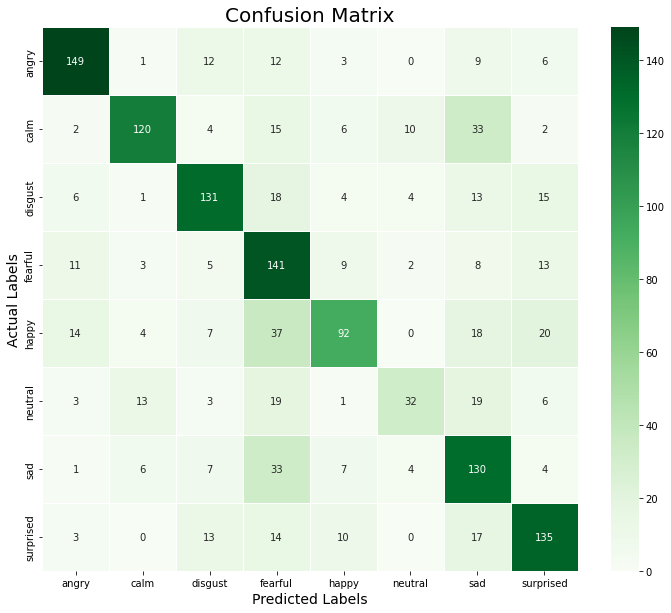

In [326]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in Ohe.categories_] , columns = [i for i in Ohe.categories_])
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()